# Introduction

This notebook is part of the publication **The NCI Imaging Data Commons as a platform for reproducible research in computational pathology**, which describes two experiments that outline how the Imaging Data Commons (IDC) can be used for reproducible computational pathology research. The two experiments are based on a common use case: the AI-based classification of lung tissue regions into either non-neoplastic (normal), adenocarcinoma (LUAD), or squamous cell carcinoma (LSCC) tissue. 
This notebook implements the **first experiment**, which uses the IDC for a complete development process, including model training and validation on TCGA data. The [second experiment](https://github.com/ImagingDataCommons/idc-comppath-reproducibility/blob/main/lung_cancer_experiment_2.ipynb) applies a pre-trained model from the first experiment to independent data from the CPTAC project.  

This notebook is intended to be run with Google Vertex AI. The total runtime is about 1 day and 18 hours.

In summary, this notebook shows:

- how to select and access slide microscopy data from the IDC;
- how to process slide microscopy images in DICOM format;
- how to **develop, train and apply a convolutional neural network (CNN) model** and visualize the results exploiting the IDC platform.

## Manual settings

Before the notebook can run automatically, some manual set-up is required as described in the following. 

**Step 1: Set-up of a Google Cloud Platform project and a Google Vertex AI notebook**

- **Set-up of a Google Cloud Platform project**: In order to run this notebook with Google Vertex AI and access image data from the IDC, you need to have a Google identity and a Google Cloud Platform (GCP) project. If you don't have one already, you can create your own project by performing the four steps described [here](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part1_prerequisites.ipynb) in section "Activate GCP for your account and create a GCP project". Please make sure to enable billing as this notebook can not run free of cost and to note the ID of your GCP project, as you will need it later.

- **Set-up of a Google Vertex AI instance:** This notebook is intended to be run with a "customized" instance of Google Vertex AI. Further information on how to set up such an instance ca be found [here](https://cloud.google.com/vertex-ai/docs/workbench/user-managed/create-new#create-with-options) (status as of 01.03.2023). Please be aware that the Google Vertex AI instances we refer to are officially called "user-managed notebooks", which may cause confusion. During set-up, we recommend to adopt the following settings:
  - Attributes > Region: us-xxx (any region in the United States)
  - Environment > Operating System: Debian 10
  - Environment > Environment: TensorFlow Enterprise 2.8 (with LTS and Intel MKL-DNN/MKL)
  - Machine configuration > Machine type: n1-standard-8 (8 vCPU, 30GB memory)
  - GPUs > GPU type: NVIDIA Tesla T4
  - GPUs > Number of GPUs: 1
  - GPUs > Install NVIDIA GPU driver automatically for me: check
  - Disk(s) > Boot disk type: Standard Persistent Disk
  - Disk(s) > Boot disk size: 100 GB
  - Disk(s) > Data disk type: SSD Persistent Disk
  - Disk(s) > Data disk size: 200 GB

  If you successfully created your Google Vertex AI instance you should be able to see it in the in the Vertex AI Workbench after opening this link: https://console.cloud.google.com/vertex-ai/workbench. 

- **Open this notebook with Google Vertex AI**: In the instances list of the Vertex AI Workbench, click "Open Jupyterlab" to open the JupyterLab environment in your browser. Launch a terminal and type `git clone https://github.com/ImagingDataCommons/idc-comppath-reproducibility.git` to clone the Github directory containing this notebook to your Vertex AI instance. Navigate to this notebook in the file browser and open it. 


**Step 2: Ensure package dependencies:** Running this cell installs required libraries that are not automatically pre-installed in the Vertex AI instance. After successfull installation, restart the kernel by selecting "Kernel > Restart Kernel" in the header of the JupyterLab environment. 

In [ ]:
!pip3 install pydicom==2.3.0 wsidicom==0.3.2

**Step 3: Ensure GPU availability:** This notebook is intended to be run with a GPU. The statement below checks if the GPU is readily available and outputs the type and ID of the GPU used. 

In [ ]:
gpu_list = !nvidia-smi --list-gpus
has_gpu = False if 'failed' in gpu_list[0] else True
print(has_gpu, gpu_list)

**Step 4: Specify your Google Cloud Platform project ID:** Set `GC_PROJECT_ID` below to the ID of your GCP project. 

In [ ]:
GC_PROJECT_ID = 'idc-pathomics-000'

**Step 5: Save and run the notebook:** Save the current version of the notebook by clicking on the respective icon in the upper right corner or pressing `Strg + S`. We recommend to use [papermill](https://papermill.readthedocs.io/en/latest/) for executing long-running notebooks like this, as it eliminates the need to maintain a permanent browser connection. Papermill is already pre-installed on the Google Vertex AI instance and can be called by executing
`papermill NOTEBOOK_PATH OUTPUT_NOTEBOOK_PATH` on the JupyterLab command line.

## Utility Code 

Utility functionality for accessing whole-slide images (WSIs) in the IDC and for evaluating results is summarized in the idc_comppath_reproducibility package. The code is available open source and can be re-used for similar use cases.

## Imports

In [ ]:
import os
import glob 
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from PIL import Image
from matplotlib.ticker import MaxNLocator

from idc_comppath_reproducibility.utils import create_slides_metadata, get_stratified_subsample, load_tile
from idc_comppath_reproducibility.wsi import WSIOpener, WSI
from idc_comppath_reproducibility.tile_extraction import extract_tiles_if_not_existent
from idc_comppath_reproducibility.dataset_splitting import split_tile_list
from idc_comppath_reproducibility.tile_list import TileList
from idc_comppath_reproducibility.tile_list_batch_iterator import TileListBatchIterator, get_tile_generator
from idc_comppath_reproducibility.model import InceptionModel
from idc_comppath_reproducibility.predictions import Predictions
from idc_comppath_reproducibility.roc import perform_tile_based_roc_analysis, perform_slide_based_roc_analysis, summarize_roc_values  
from idc_comppath_reproducibility.heatmap import select_slides_for_heatmap, plot_colormap_legend, generate_heatmap
from idc_comppath_reproducibility.global_variables import CLASS_LABEL_TO_INDEX_MAP, NUM_CLASSES

## Global constants

In [ ]:
# Demo mode produces a model at lower resolution for the demo mode of experiment 2. 
DEMO_MODE = False

if DEMO_MODE:
    NUM_SLIDES = None
    PIXEL_SPACING = 0.002 
    TILE_SIZE = 128
    BATCH_SIZE = 64
    NUM_TRAIN_EPOCHS = 5
else:
    NUM_SLIDES = None
    PIXEL_SPACING = 0.001
    TILE_SIZE = 256
    BATCH_SIZE = 64
    NUM_TRAIN_EPOCHS = 10

## Random seeds 

In [ ]:
# To enable reproducibility we aim to make all operations in this notebook deterministic. An important part to this is setting random seeds. 
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Directories
The following directory structure is created to store data and results.
```
.
├── data_dir  
│   └── tiles_dir: storage of image tiles. 
└── workspace_dir
    └── experiment_dir: storage of intermediate and final results. 
```

In [ ]:
curr_pilot = !whoami
data_dir = os.path.join('/home', curr_pilot[-1], 'data')
workspace_dir = os.path.join('/home', curr_pilot[-1], 'workspace')

for directory in [data_dir, workspace_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
run_id = 'res_%s_ts_%sx%s_%s' %(PIXEL_SPACING, TILE_SIZE, TILE_SIZE, time.strftime("%Y%m%d_%H%M%S"))

experiment_dir = os.path.join(workspace_dir, run_id)
tiles_dir = os.path.join(data_dir, 'tcga_tiles_res_%s_ts_%sx%s' %(PIXEL_SPACING, TILE_SIZE, TILE_SIZE))

for directory in [experiment_dir, tiles_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

## Data selection

For most computational pathology experiments, the first step is to select a cohort of WSIs by filtering for the desired metadata attributes. 

The IDC uses the DICOM standard for data representation. Here, a WSI corresponds to a series of DICOM image objects, each representing the slide at a different resolution. Each DICOM object is stored as a separate DICOM file. Cohort selection is done best by executing BigQuery SQL statements against the **bigquery-public-data.idc_v11.dicom_all** table, which lists all available DICOM files (rows) with the corresponding metadata atrributes (columns).

The following BigQuery SQL statement retrieves all DICOM files (including their metadata) in the TCGA-LUAD and TCGA-LUSC collections that are of interest for our use case.

In [ ]:
%%bigquery bq_results_df --project=$GC_PROJECT_ID

-- First, create subqueries to facilitate data selection from the dicom_all table.
-- Several DICOM attributes are renamed to be more intuitive
-- (e.g. 'TotalPixelMatrixColumns' is renamed to 'width').
WITH
  -- The 'sm_images' subquery summarizes basic metadata of slide microscopy images (SM).
  sm_images AS (
    SELECT
      -- digital_slide_id: unique numeric identifier of a digital slide, i.e., a digital image of a physical slide.
      SeriesInstanceUID AS digital_slide_id, 
      -- case_id: unique numeric identifier of the study in the context of which the ditial slide was created.
      StudyInstanceUID AS case_id,
      -- physical_slide_id: unique numeric identifier of the physical slide as prepared in the wet lab. 
      ContainerIdentifier AS physical_slide_id,
      -- patient_id: unique numeric identifier of the patient from whose tissue the physical slide was obtained.
      PatientID AS patient_id,
      -- width: image width in pixels.
      TotalPixelMatrixColumns AS width, 
      -- height: image height in pixels. 
      TotalPixelMatrixRows AS height,
      -- collection_id: numeric or character sequence describing the dataset the physical slide is part of.
      collection_id,
      -- crdc_instance_uuid: universally unique identifier of the DICOM instance.
      crdc_instance_uuid,
      -- gcs_url: GCS URL needed to access the DICOM file
      gcs_url, 
      -- pixel_spacing: image pixel spacing in mm/px 
      CAST(SharedFunctionalGroupsSequence[SAFE_OFFSET(0)].
              PixelMeasuresSequence[SAFE_OFFSET(0)].
              PixelSpacing[SAFE_OFFSET(0)] AS FLOAT64) AS pixel_spacing, 
      -- compression: compression type 
      CASE TransferSyntaxUID
          WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
          WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
          ELSE 'other'
      END AS compression, 
    FROM
      -- we are using version 11 of the IDC data
      bigquery-public-data.idc_v11.dicom_all
    WHERE
      -- limit query to slide microscopy images (SM) excluding non-volume images like label images
      Modality = 'SM' AND ImageType[OFFSET(2)] = 'VOLUME'
  ),
  -- The 'tissue_types' subquery indicates whether a slides contains normal, tumor or other tisse.
  tissue_types AS (
    SELECT DISTINCT *
    FROM (
      SELECT
        SeriesInstanceUID AS digital_slide_id,
        CASE steps_unnested2.CodeValue
            WHEN '17621005' THEN 'normal' -- meaning: 'Normal' (i.e., non neoplastic)
            WHEN '86049000' THEN 'tumor' -- meaning: 'Neoplasm, Primary'
            ELSE 'other' -- meaning: 'Neoplasm, Metastatic'
        END AS tissue_type
      FROM
        bigquery-public-data.idc_v11.dicom_all
        CROSS JOIN
          UNNEST (SpecimenDescriptionSequence[SAFE_OFFSET(0)].PrimaryAnatomicStructureSequence) AS steps_unnested1
        CROSS JOIN
          UNNEST (steps_unnested1.PrimaryAnatomicStructureModifierSequence) AS steps_unnested2
    )
  ),
  -- The 'specimen_preparation_sequence_items' subquery provides additional information
  -- about the preparation of the slide, such as the embedding medium.
  specimen_preparation_sequence_items AS (
    SELECT DISTINCT *
    FROM (
      SELECT
        SeriesInstanceUID AS digital_slide_id,
        steps_unnested2.ConceptNameCodeSequence[SAFE_OFFSET(0)].CodeMeaning AS item_name,
        steps_unnested2.ConceptCodeSequence[SAFE_OFFSET(0)].CodeMeaning AS item_value
      FROM
        bigquery-public-data.idc_v11.dicom_all
        CROSS JOIN
          UNNEST (SpecimenDescriptionSequence[SAFE_OFFSET(0)].SpecimenPreparationSequence) AS steps_unnested1
        CROSS JOIN
          UNNEST (steps_unnested1.SpecimenPreparationStepContentItemSequence) AS steps_unnested2
    )
  )

-- Select all DICOM images from the TCGA-LUAD / TCGA-LUSC datasets that are JPEG/JPEG2000 compressed 
-- and contain normal or tumor tissue in frozen tissue sections. The results are ordered by their 
-- crdc_instance_uuid to ensure deterministic output order which is important for reproducibility.
SELECT
  a.*,
  b.tissue_type,
  (REPLACE (REPLACE(a.collection_id, 'tcga_luad', 'luad'), 'tcga_lusc', 'lscc')) AS cancer_subtype
FROM 
  sm_images AS a
  JOIN tissue_types AS b ON b.digital_slide_id=a.digital_slide_id
  JOIN specimen_preparation_sequence_items AS c ON c.digital_slide_id=a.digital_slide_id 
WHERE
  (a.collection_id = 'tcga_luad' OR a.collection_id = 'tcga_lusc')
  AND a.compression != 'other'
  AND (b.tissue_type = 'normal' OR b.tissue_type = 'tumor')
  AND (c.item_name = 'Embedding medium' AND c.item_value = 'Tissue freezing medium')
ORDER BY crdc_instance_uuid

The metadata are reorganized into a dataframe containing one row per WSI, which is also stored in the `experiment_dir` directory. In case of the demo mode, a stratified subsample is selected for the analysis. 

In [ ]:
slides_metadata = create_slides_metadata(bq_results_df)
if NUM_SLIDES: 
    slides_metadata = get_stratified_subsample(slides_metadata, NUM_SLIDES, random_state=seed_value)

In [ ]:
# Assert uniqueness of slide_id values
assert(slides_metadata['physical_slide_id'].is_unique)

# Assert validity of class labels
assert set(slides_metadata['tissue_type'].unique()) == set(['normal', 'tumor'])
assert set(slides_metadata['cancer_subtype'].unique()) == set(['luad', 'lscc'])

display(slides_metadata.head())
print('Total number of slides: ', len(slides_metadata))
nr_slides = slides_metadata.groupby('cancer_subtype').size()
nr_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()
print('--> %d slides from %d LUAD patients' % (nr_slides['luad'], nr_patients['luad']))
print('--> %d slides from %d LSCC patients' % (nr_slides['lscc'], nr_patients['lscc']))

slides_metadata_path = os.path.join(experiment_dir, 'slides_metadata.csv')
slides_metadata.to_csv(slides_metadata_path, index=False)

The following code visualizes the frequencies of numbers of slides per patient (left) and the proportions of slides derived from healthy or tumor tissue (right). The figure is also stored in the `experiment_dir` directory.

In [ ]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Number of slides per patient 
slides_per_patient = slides_metadata.groupby(['patient_id']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color='gray')
ax1.update({'xlabel': 'Number of slides', 'ylabel': 'Number of patients'})
ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # Force integer labels on x-axis

# Distribution of tissue types
plot2 = sns.histplot(data=slides_metadata, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C1', 'C2'], ax=ax2, shrink=0.7)
ax2.update({'xlabel': 'Cancer subtype', 'ylabel': 'Number of slides'})
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

fig1.savefig(os.path.join(experiment_dir, 'slides_distribution.png'))

Any slide can also be viewed and explored in detail using the IDC viewer.

In [ ]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

print(get_idc_viewer_url(slides_metadata['case_id'].iloc[0]))

## Preprocessing



For each slide, the DICOM file that shows the slide at the required resolution is accessed and subdivided into non-overlapping rectangular tiles. Tiles showing more background than tissue as determined by the ```is_foreground``` function, are discarded. 
The resulting list of foreground tiles is subsequently split into a training (70%), validation (15%) and test (15%) set. It is ensured that all tiles from a particular patient are assigned to only one set. The list of tiles are also stored in the `experiment_dir` directory. 

 

In [ ]:
%%time
def is_foreground(tile: Image.Image) -> bool:
    """
    Function to determine if a tile shows mainly tissue (foreground) or background.
    Returns True if tile shows <= 50% background and False otherwise.
    """ 
    grey = tile.convert(mode='L')
    thresholded = grey.point(lambda x: 0 if x < 220 else 1, mode='F')
    avg_bkg = np.average(np.array(thresholded))
    return avg_bkg <= 0.5   

wsi_opener = WSIOpener(slides_metadata)
foreground_tile_list = extract_tiles_if_not_existent(wsi_opener, tiles_dir, TILE_SIZE, PIXEL_SPACING, 
                                                     accept_function=is_foreground)

In [ ]:
tile_list_train, tile_list_val, tile_list_test =\
    split_tile_list(foreground_tile_list, slides_metadata,\
                    proportions=[0.7, 0.15, 0.15], random_state=0)
tile_list_train.save(os.path.join(experiment_dir, 'tile_list_train.csv'))
tile_list_val.save(os.path.join(experiment_dir, 'tile_list_val.csv'))
tile_list_test.save(os.path.join(experiment_dir, 'tile_list_test.csv'))

Some example tiles from the training dataset are shown below. The figure is also stored in the `experiment_dir` directory.

In [ ]:
fig2, axes = plt.subplots(1,6, figsize=(18,3))
fig2.suptitle('Tiles from training data')
for i in range(6): 
    image_id, tile_pos = tile_list_train.get_random_tile_info()
    tile_image = load_tile(tiles_dir, (image_id, tile_pos)) 
    axes[i].imshow(tile_image)
    axes[i].set_title(slides_metadata.loc[image_id]['reference_class_label'])
    axes[i].axis('off')
fig2.savefig(os.path.join(experiment_dir, 'training_tiles.png'))

## Training

For the classification, we use the well-established CNN architecture InceptionV3 as implemented by Keras and depicted in the figure below [[Szegedy et al., 2015]](https://arxiv.org/abs/1512.00567). The loss function is defined as categorical cross entropy between the true labels and the network's predictions. The RMSprop optimizer is applied for learning with default values and a learning rate of 0.01. The metric observed during learning is the Area under the curve (AUC) of the receiver operating characteristic (ROC) curve.

Model checkpoints are automatically stored in the `experiment_dir` directory after each epoch in which the validation AUC improves. 
The final model is selected as the one with the maximum AUC on the validation dataset.

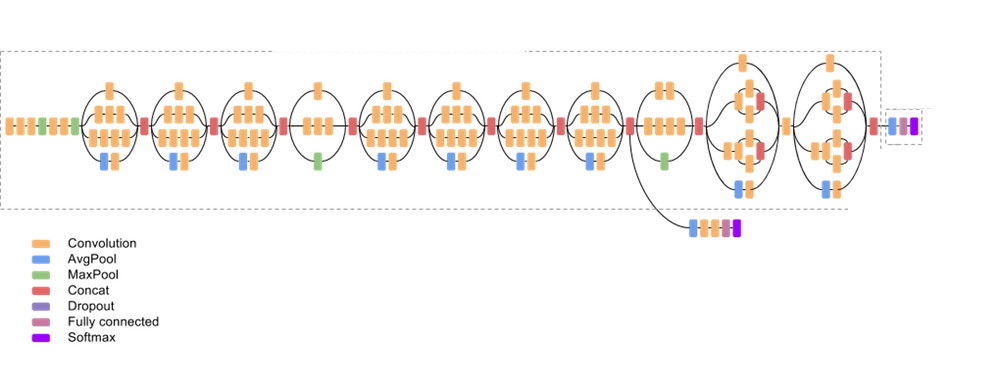

In [ ]:
train_generator = get_tile_generator(tile_list_train, tiles_dir,
            TILE_SIZE, PIXEL_SPACING, BATCH_SIZE,
            NUM_CLASSES, slides_metadata, shuffle=True)
val_generator = get_tile_generator(tile_list_val, tiles_dir,
            TILE_SIZE, PIXEL_SPACING, BATCH_SIZE,
            NUM_CLASSES, slides_metadata, shuffle=False)

# Model set-up
model = InceptionModel(num_classes=NUM_CLASSES, input_shape=(TILE_SIZE,TILE_SIZE,3), learning_rate=0.01)

In [ ]:
%%time 
# Model training
model.train(train_generator, tile_list_train.get_num_tiles(), BATCH_SIZE, NUM_TRAIN_EPOCHS, experiment_dir, val_generator, tile_list_val.get_num_tiles()) 

In [ ]:
# Load the best model (= model with maximum validation AUC)
checkpoints = glob.glob(os.path.join(experiment_dir, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the maximum validation AUC 
best_model = InceptionModel.load(best_model_dir)

## Prediction

 
The predictions on the test set are collected in an instance of the class
```Prediction```, and also stored in CSV format in the `experiment_dir` directory to make subsequent evaluation easily repeatable. 

In [ ]:
def predict(model, tile_list: TileList, tiles_dir: str, slides_metadata: pd.DataFrame) -> Predictions:
    """
    Function to perform inference for a certain set of tiles using a given model.
    Returns per-tile predictions as obtained from the model inference plus necessary metadata, e.g., 
    the tile's position in the WSI. 
    """ 
    image_ids = []
    tile_positions = []
    reference_class_indices = []
    predicted_class_probabilities = []

    test_batch_iterator = TileListBatchIterator(tile_list, tiles_dir,
                                                TILE_SIZE, PIXEL_SPACING, BATCH_SIZE)

    for batch_images, batch_tile_infos in test_batch_iterator:
        batch_predicted_class_probabilities = best_model.make_prediction(batch_images).numpy()
        image_ids.extend([tile_info[0] for tile_info in batch_tile_infos])
        tile_positions.extend([tile_info[1] for tile_info in batch_tile_infos])
        reference_class_indices.extend(\
            [CLASS_LABEL_TO_INDEX_MAP[slides_metadata.loc[tile_info[0]]['reference_class_label']] for tile_info in batch_tile_infos])
        predicted_class_probabilities.extend(batch_predicted_class_probabilities.tolist())


    dictionary = {'image_id': image_ids, 'tile_position': tile_positions, 
            'reference_class_index': reference_class_indices,
            'predicted_class_index': [p.index(max(p)) for p in predicted_class_probabilities], 
            'predicted_class_probabilities': predicted_class_probabilities}
    predictions = Predictions(pd.DataFrame(dictionary)) 
    predictions.save(os.path.join(experiment_dir, 'predictions.csv'))
    return predictions

In [ ]:
%%time
predictions = predict(best_model, tile_list_test, tiles_dir, slides_metadata)

## Evaluation

In the following, the performance of this model is evaluated quantitatively by means of ROC curves and observed qualitatively using heatmap visualization. 

**A ROC analysis** (one-vs-rest) for each of the three classes (normal, LUAD, LSCC) is performed on **tile-level** (tile-based ROC) and on **slide-level** (slide-based ROC). For the slide-level analysis the probabilities for each slide are aggregated by averaging the probabilities of the corresponding tiles. Respective Area under the ROC curve (AUC) values are reported in the table below. ROC curves are also visualized below. Both the table and the ROC curve plots are also stored in the `experiment_dir` directory. 

In [ ]:
tile_roc_analysis = perform_tile_based_roc_analysis(predictions)
slide_roc_analysis = perform_slide_based_roc_analysis(predictions)
roc_values = summarize_roc_values(tile_roc_analysis, slide_roc_analysis)
roc_values.to_csv(os.path.join(experiment_dir, 'roc_analysis.csv'))

In [ ]:
fig4, axes = plt.subplots(1,2, figsize=(10,4))
tile_roc_analysis.plot(axes[0]) 
slide_roc_analysis.plot(axes[1])
fig4.savefig(os.path.join(experiment_dir, 'roc_analysis.png'))

**Heatmaps** are generated for visually inspecting the network's predictions for three exemplary slides. The color of each tile in the heatmap corresponds to the class assigned by our model. The hue indicates how confident the network is in this classification. Hereby, a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap. Heatmaps are also stored in the `experiment_dir` directory.

In [ ]:
hm_slides_metadata = select_slides_for_heatmap(predictions, slides_metadata)

plot_colormap_legend()
fig5, axes = plt.subplots(len(hm_slides_metadata.index), 2, figsize=(10, 9))
for i, (image_id, slide_metadata) in enumerate(hm_slides_metadata.iterrows()):
    wsi = WSI(slide_metadata)
    thumbnail = wsi.get_thumbnail()
    true_tissue_type = slide_metadata['reference_class_label']
    heatmap = generate_heatmap(predictions, image_id)
    axes[i,0].imshow(heatmap)
    axes[i,1].imshow(thumbnail)
    axes[i,1].set_title(true_tissue_type)
    axes[i,0].axis('off')
    axes[i,1].axis('off')
fig5.savefig(os.path.join(experiment_dir, 'heatmaps.png'))

---
*The results shown here are in whole or part based upon data generated by the The Cancer Genome Atlas (TCGA) Research Network and the National Cancer Institute Clinical Proteomic Tumor Analysis Consortium (CPTAC).*

*Copyright 2023 Fraunhofer MEVIS and Harvard Medical School. Redistribution and use of this notebook, with or without modification, are permitted under the terms of the [3-Clause BSD License](https://opensource.org/licenses/BSD-3-Clause).*

